In [1]:
#!/usr/bin/env python
# coding: utf-8

import os, sys
import logging
import numpy as np

import xarray as xr
import xarray.ufuncs as xu
import xrft
import pandas as pd

from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy

from cross_defPlot import *
from cross_compute import *

from dask.distributed import Client, LocalCluster
#
# Initialisation d'un cluster de 32 coeurs
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=4, silence_logs='error', protocol = 'tcp://',
                      host = '137.129.155.67')
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://137.129.155.67:8787/status,
Dashboard: http://137.129.155.67:8787/status,Workers: 1
Total threads: 4,Total memory: 78.61 GiB
Status: running,Using processes: False
Comm: tcp://137.129.155.67:36757,Workers: 1
Dashboard: http://137.129.155.67:8787/status,Total threads: 4
Started: Just now,Total memory: 78.61 GiB
Comm: tcp://137.129.155.67:47793,Total threads: 4
Dashboard: http://137.129.155.67:44301/status,Memory: 78.61 GiB
Nanny: None,


In [2]:
### Parameter for the analysis
year = 2009
latitude = 10.5
longitude = 179

fileBox = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/ANALYSIS/BOXINDO/'

wave_TCWV = ['TCWV_TD', 'TCWV_MJO', 'TCWV_Kelvin', 'TCWV_Rossby', 'TCWV_MRG']  
wave_OLR = ['OLR_TD', 'OLR_MJO', 'OLR_Kelvin', 'OLR_Rossby', 'OLR_MRG']
wave = np.concatenate((wave_TCWV, wave_OLR), axis =0 )
coeff = 1

In [3]:
day1 = '2009-07-01'
day2 = '2009-10-01'

ds_VAR, ds_TCWV, ds_OLR = openDATA(year, 'JAS')
ds_TCWV = ds_TCWV.sel(time = slice(day1, day2), lat = slice(5,15), lon = slice(110,120)).persist()
ds_OLR = ds_OLR.sel(time = slice(day1, day2), lat = slice(5,15), lon = slice(110,120)).persist()

ds_TCWV = ds_TCWV.mean(dim= ['lat','lon']).persist()
ds_OLR = ds_OLR.mean(dim= ['lat','lon']).persist()

ds_FILTER = xr.merge([ds_TCWV, ds_OLR])

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key

In [8]:
# WIG = xr.open_mfdataset(indir_data_WIG + '*' + str(year) + '*.nc', chunks = {'time' : 10}, parallel=True)
# WIG = WIG.assign_coords(lon = (((WIG.lon + 180) % 360) - 180)).sortby('lon')
# WIG = WIG['OLR_WIG'].sel(lat = slice(9,19), lon = slice(-5,5)).mean(['lat','lon']).compute()


In [4]:
### Compute standard deviation
ds_std_mean = (ds_VAR**(0.5)).persist()
ds_std = ds_VAR**(0.5)
for w in wave:
    ds_FILTER = addNegative(ds_FILTER, ds_std_mean, w)
    
ds_FILTER = ds_FILTER
ds_FILTER

<xarray.Dataset>
Dimensions:            (time: 744)
Coordinates:
  * time               (time) datetime64[ns] 2009-07-01 ... 2009-10-01T21:00:00
Data variables: (12/38)
    TCWV_Kelvin        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    TCWV_Rossby        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    TCWV_MJO           (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    TCWV_MRG           (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    TCWV_EIG           (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    TCWV_WIG           (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    ...                 ...
    STD_OLR_Kelvin     (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    STD_OLR_Kelvin_N   (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    STD_OLR_Rossby     (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    STD_OLR_Rossby_N   (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    STD_OLR_MRG        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    STD_OLR_MRG_N      (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

# Series temporelle.
On moyenne chaque variable spatialement sur une boite entre 9 °N et 19°N, et entre 5 °N et 15 °N, puis on plot les séries temporelles.

In [5]:
ds_FILTER = ds_FILTER.compute()

In [6]:
ds_FILTER.to_netcdf(fileBox + 'mean_OLR_TCWV_wave.nc')

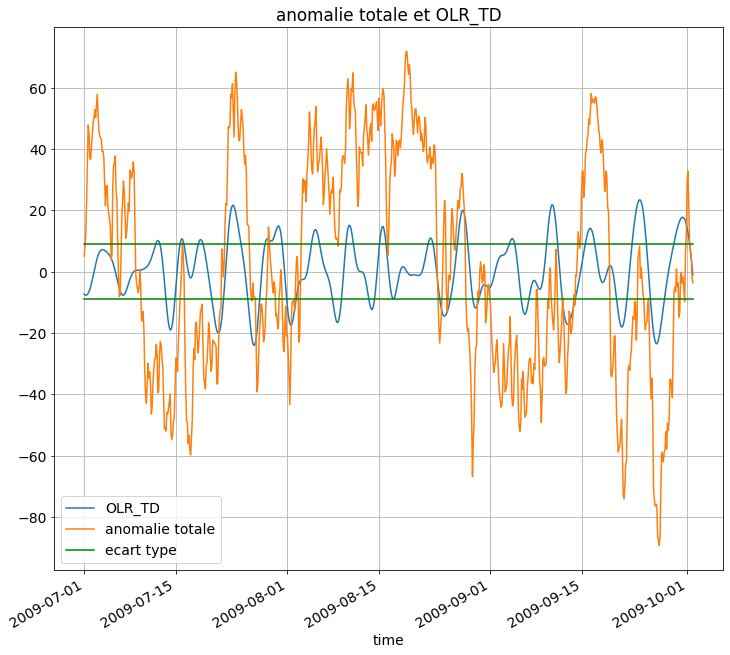

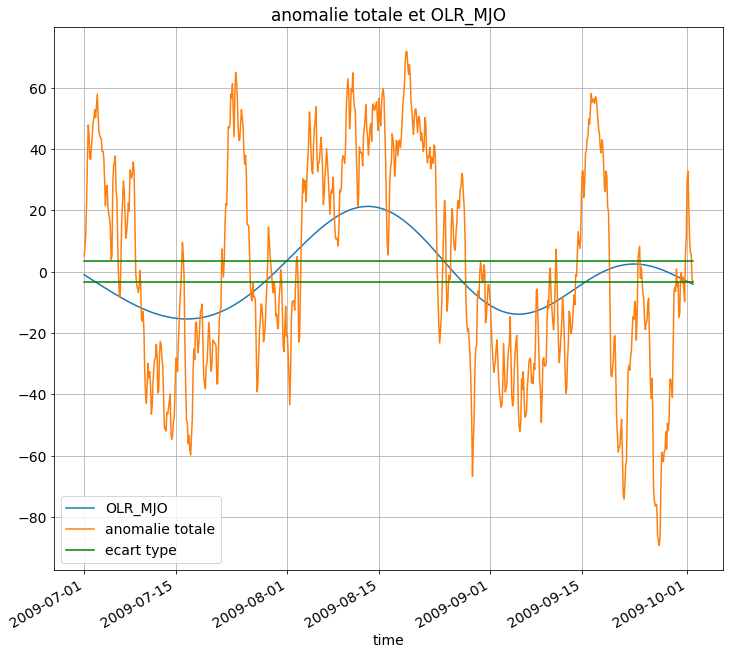

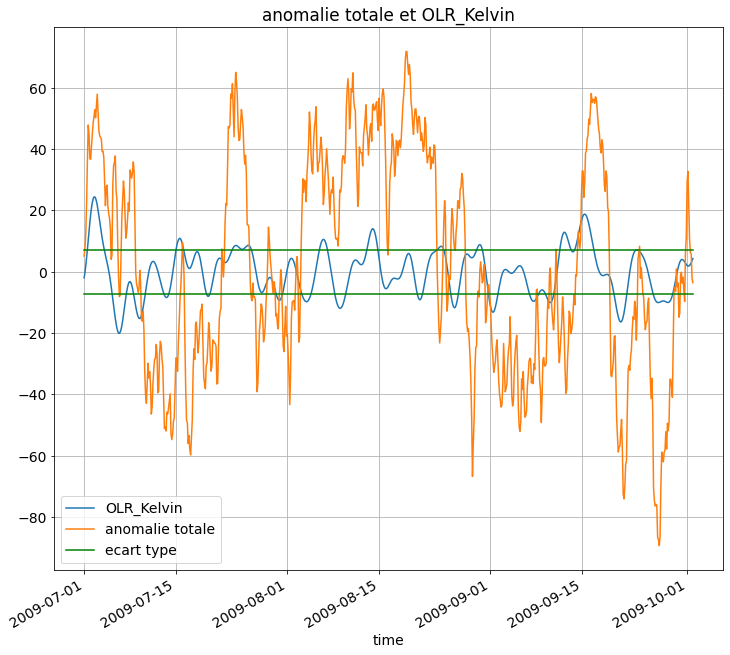

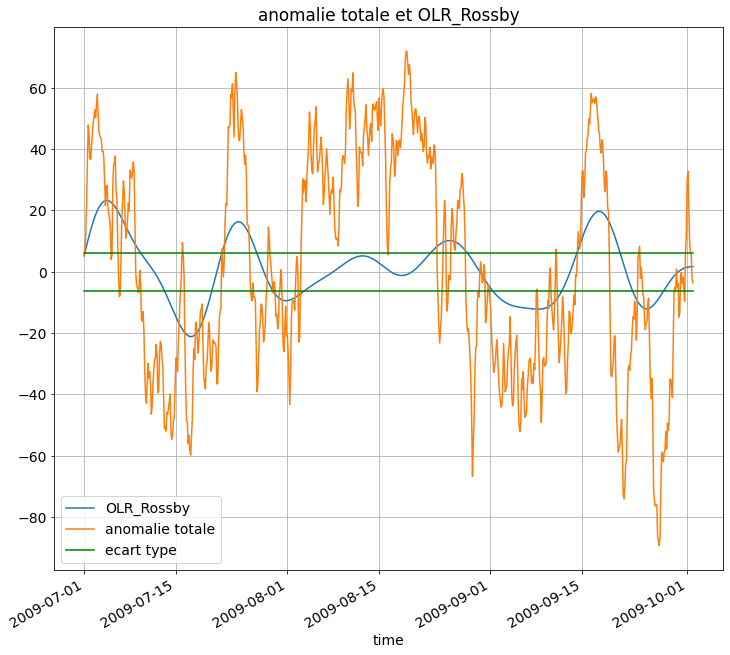

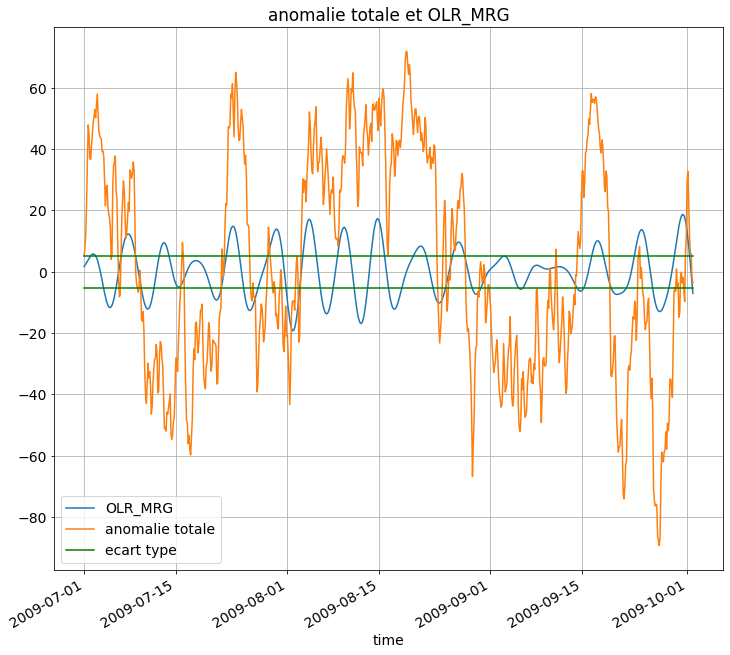

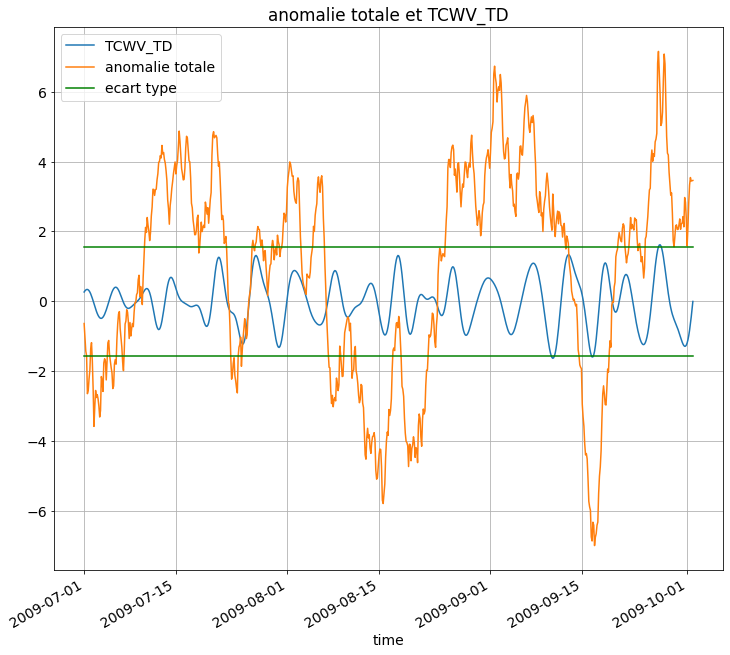

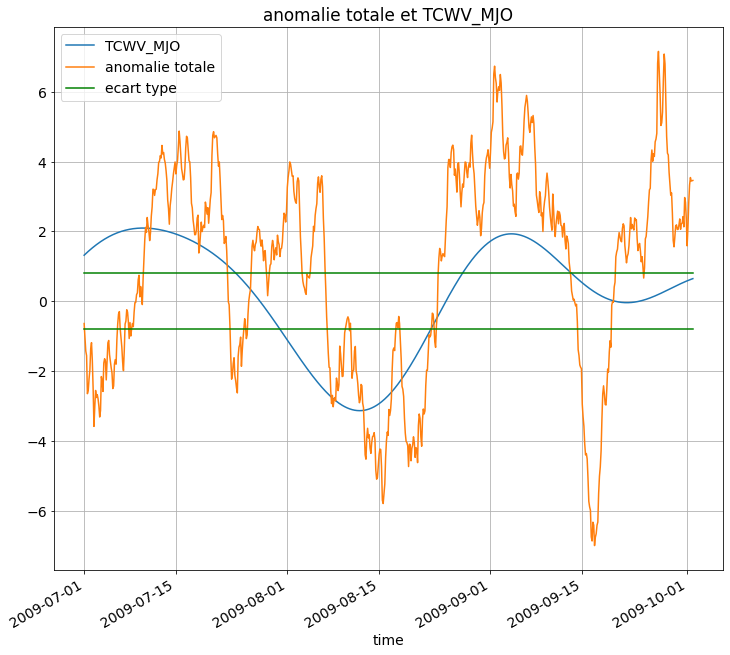

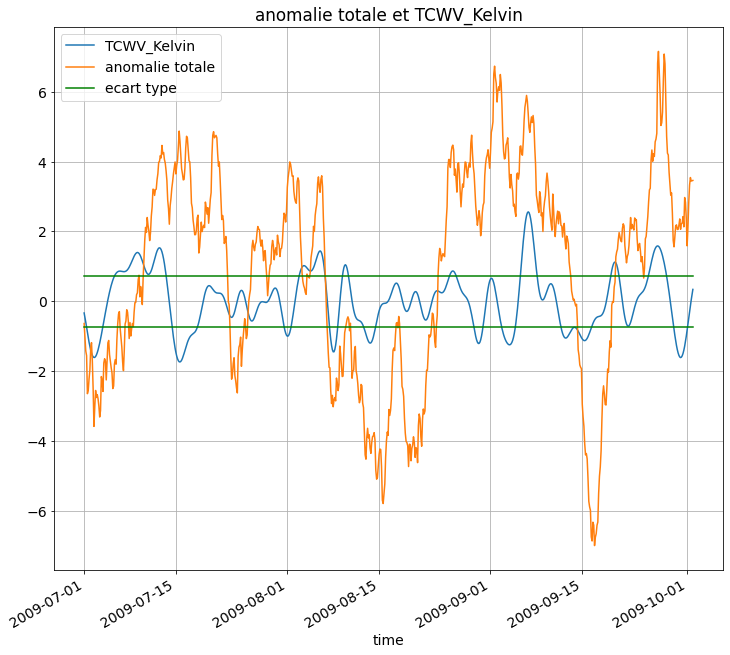

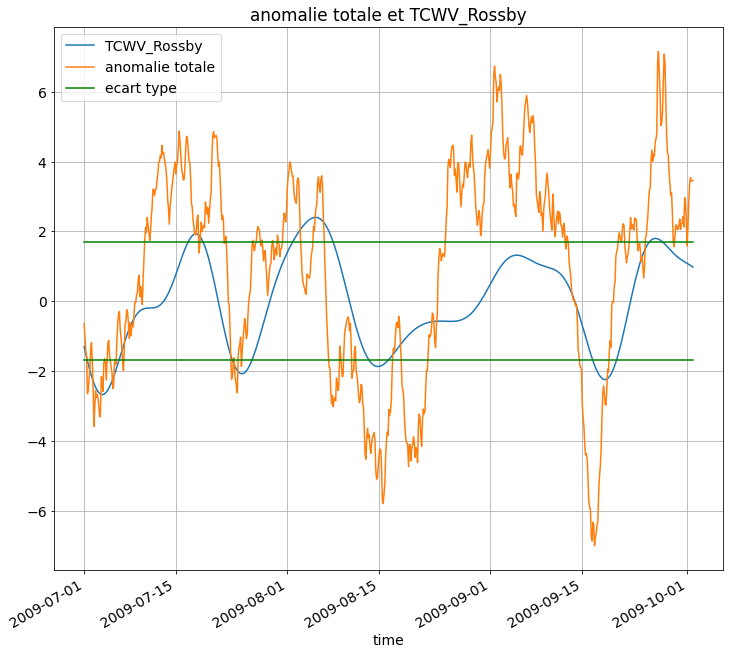

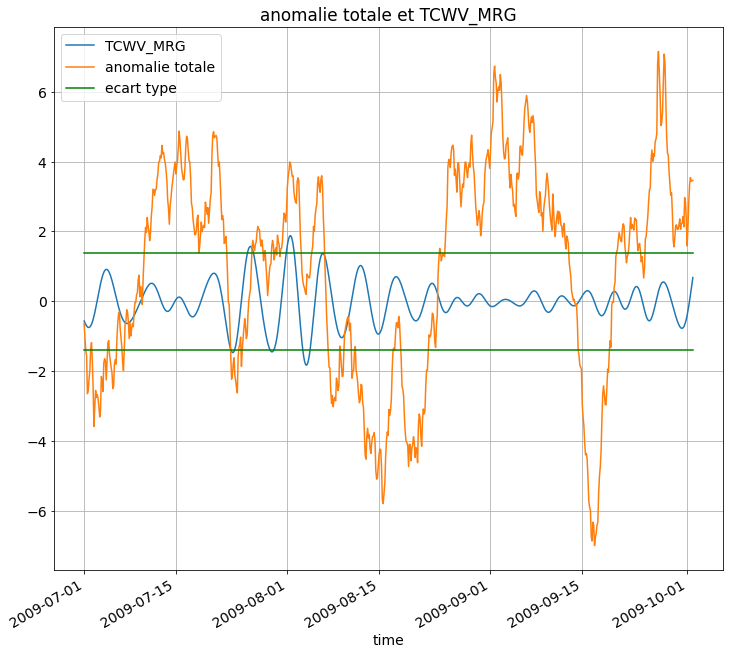

In [7]:
def plotline1D_mean(ds_FILTER, lat_Sel, lon_Sel, wave, ano):
    da_plot = ds_FILTER[wave]
    plt.rc("figure", figsize=(12,10))
    plt.figure()
    da_plot.plot(label = wave)
    ds_FILTER[ano].plot(label = 'anomalie totale')
    ds_FILTER['STD_'+ wave].plot(label = 'ecart type', color = 'green')
    ds_FILTER['STD_'+ wave + '_N'].plot(color = 'green')
    plt.legend()
    plt.ylabel('')
    plt.grid()

for w in wave_OLR:
    plotline1D_mean(ds_FILTER, latitude, longitude, w, 'OLR_ano')
    plt.title('anomalie totale et ' + w)

for w in wave_TCWV:
    plotline1D_mean(ds_FILTER, latitude, longitude, w, 'tcwv_ano')
    plt.title('anomalie totale et ' + w)

### On ne garde que les données au-dessus ou en-dessous de l'ecart type, qu'on appelle phase active de l'onde ou phase non-active.
La phase active permet de savoir si l'onde contribue à la diminution de l'anomalie pour l'OLR. La phase non active à son augmentation. 
### On sépare en trois chaque phase active ou non active.
En phase croissante, décroissante et maximum

In [136]:
### Compute of gradient
ds_FILTER = xr.open_dataset(fileBox + 'mean_OLR_TCWV_wave.nc')

In [6]:
def keepData(ds, coeff, wave_REF):
    _ds = ds.load()
    _ds[wave_REF] = xr.where( ((ds[wave_REF] <= (ds['STD_' + wave_REF +'_N'] * coeff)) | 
                                   (ds[wave_REF] >= (ds['STD_' + wave_REF] * coeff))) == True,
                                   _ds[wave_REF], np.nan)
    return _ds.compute()

def keepData_GRAD(ds, ds_GRAD, coeff, wave_REF):
    _ds_GRAD = ds_GRAD.load()
    _ds_GRAD[wave_REF] = xr.where( ((ds[wave_REF] <= (ds['STD_' + wave_REF +'_N'] * coeff)) | 
                                   (ds[wave_REF] >= (ds['STD_' + wave_REF] * coeff))) == True,
                                   _ds_GRAD[wave_REF], np.nan)
    return ds_GRAD

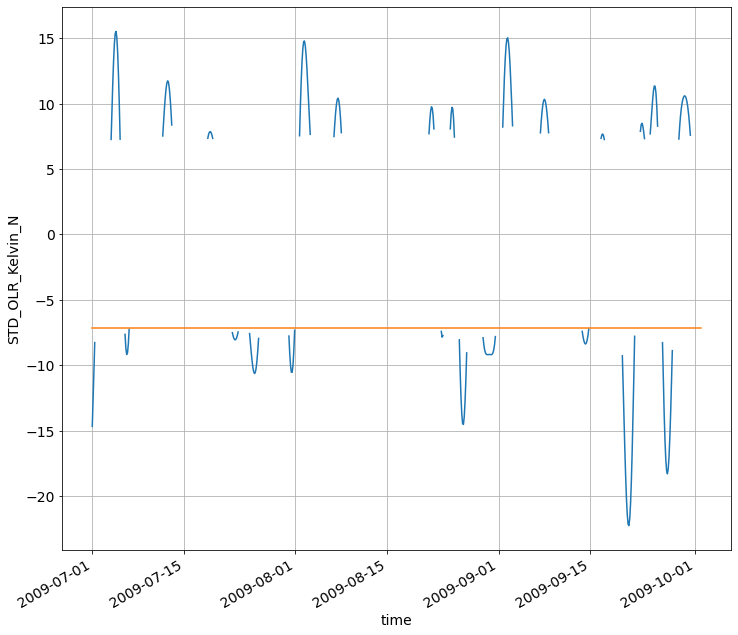

In [7]:
coeff = 1
for w in wave:
    ds_FILTER_keep = keepData(ds_FILTER, coeff, w)
    
    
ds_FILTER = xr.open_dataset('/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/ANALYSIS/BOXAFRIQUE/mean_OLR_TCWV_wave.nc')


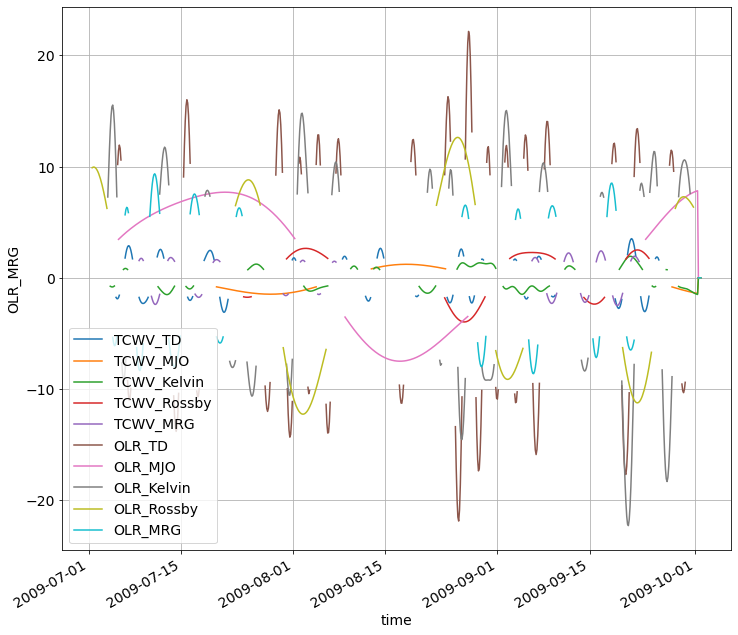

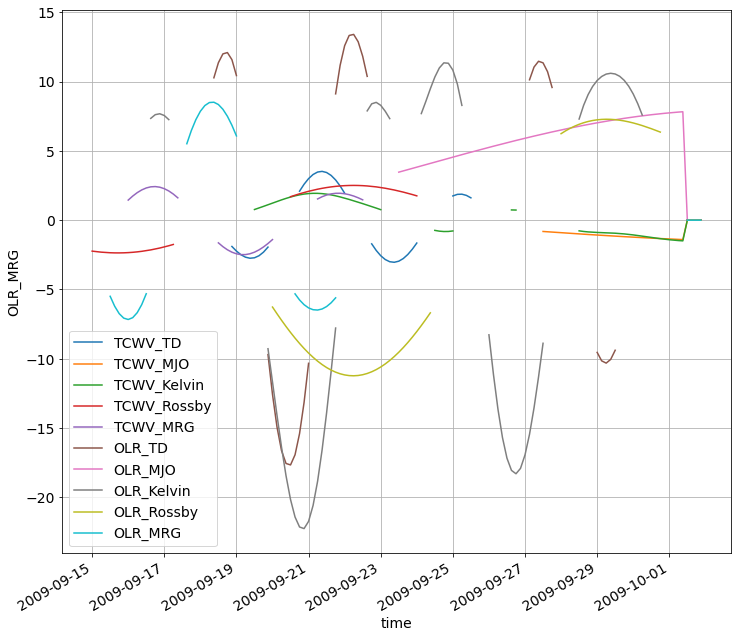

In [45]:
plt.figure()
# ds_FILTER.OLR_Kelvin.plot()
for w in wave :
    ds_FILTER_keep[w].plot(label = w)

# ds_FILTER_keep['OLR_ano'].plot(label = 'anomalie')

plt.grid()
plt.legend()
plt.show()

plt.figure()
# ds_FILTER.OLR_Kelvin.plot()
for w in wave :
    ds_FILTER_keep[w].sel(time = slice('2009-09-15','2009-10-01')).plot(label = w)
    
# ds_FILTER_keep['OLR_ano'].sel(time = slice('2009-09-15','2009-10-01')).plot(label = 'anomalie')
plt.grid()
plt.legend()
plt.show()

In [8]:
ds_FILTER = xr.open_dataset('/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/ANALYSIS/BOXINDONESIE/mean_OLR_TCWV_wave.nc')
ds_FILTER_G = ds_FILTER.chunk({'time' : -1}).differentiate('time', datetime_unit = "s").compute()
for w in wave:
    ds_FILTER_G_keep = keepData_GRAD(ds_FILTER, ds_FILTER_G, coeff, w)


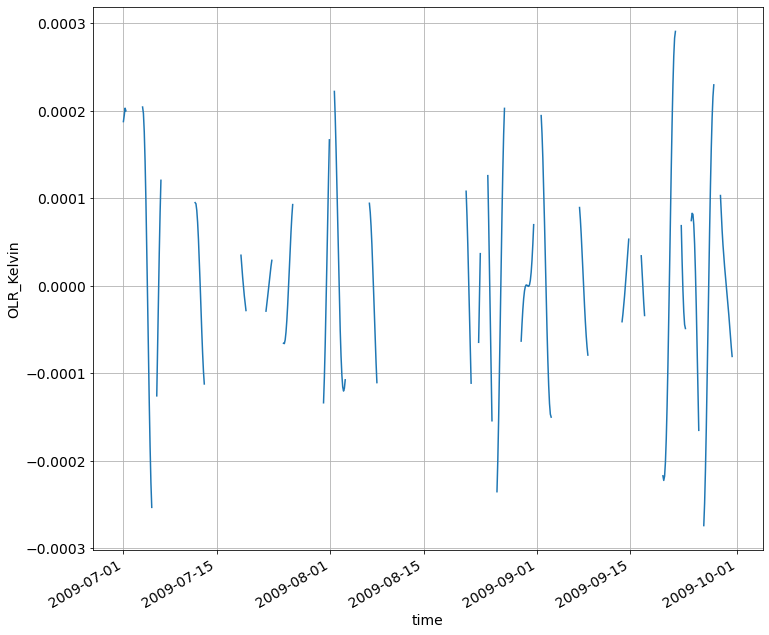

In [9]:
ds_FILTER_G = ds_FILTER.chunk({'time' : -1}).differentiate('time', datetime_unit = "s").compute()
plt.figure()
ds_FILTER_G_keep.OLR_Kelvin.plot()
plt.grid()
plt.show()

In [28]:
ds_FILTER_keep

<xarray.Dataset>
Dimensions:            (time: 744)
Coordinates:
  * time               (time) datetime64[ns] 2009-07-01 ... 2009-10-01T21:00:00
Data variables: (12/38)
    TCWV_Kelvin        (time) float64 0.8381 0.7652 nan ... -1.525 -1.533 -1.536
    TCWV_Rossby        (time) float64 nan nan nan nan nan ... nan nan nan nan
    TCWV_MJO           (time) float64 nan nan nan nan ... -1.428 -1.441 -1.453
    TCWV_MRG           (time) float64 nan nan nan nan nan ... nan nan nan nan
    TCWV_EIG           (time) float64 -0.2151 -0.1434 -0.02206 ... 0.0781 0.1649
    TCWV_WIG           (time) float64 0.1405 0.394 0.568 ... 0.0738 0.03048
    ...                 ...
    STD_OLR_Kelvin     (time) float64 7.187 7.187 7.187 ... 7.187 7.187 7.187
    STD_OLR_Kelvin_N   (time) float64 -7.187 -7.187 -7.187 ... -7.187 -7.187
    STD_OLR_Rossby     (time) float64 6.235 6.235 6.235 ... 6.235 6.235 6.235
    STD_OLR_Rossby_N   (time) float64 -6.235 -6.235 -6.235 ... -6.235 -6.235
    STD_OLR_MRG        (time) float64 5.224 5.224 5.224 ... 5.224 5.224 5.224
    STD_OLR_MRG_N      (time) float64 -5.224 -5.224 -5.224 ... -5.224 -5.224

In [42]:
def separatephase(ds_FILTER_keep, ds_FILTER_G_keep, wave):
    print(wave)
    from scipy.signal import find_peaks

    numpy_DATA = ds_FILTER_keep[wave].values
    numpy_DATA[:4] = np.nan
    numpy_DATA[-4:] = 0


    maxm, _ = find_peaks(numpy_DATA, distance = 20)
    minm, _ = find_peaks(numpy_DATA*-1, distance = 20)

    nb_jour_inactive = np.ones(np.size(maxm), dtype= int) * 0
    nb_jour_active = np.ones(np.size(minm), dtype= int) * 0
    j = -1
    k = -1
    for t in range(ds_FILTER_G_keep[wave].time.size - 1) :
        da = ds_FILTER_keep[wave].isel(time = t)
        _da = ds_FILTER_keep[wave].isel(time = t + 1)
        if ((np.isnan(da) == True) & (np.isnan(_da) == False) & (_da > 0)):
            j = j + 1
            continue
        elif ((np.isnan(da) == True) & (np.isnan(_da) == False) & (_da < 0)):
            k = k + 1
            continue
        elif (((np.isnan(da) == False)) & (da > 0)):
            nb_jour_inactive[j] = nb_jour_inactive[j] + 1
        elif (((np.isnan(da) == False)) & (da < 0)):
            nb_jour_active[k] = nb_jour_active[k] + 1

    nb_jour_active_tier = (nb_jour_active/3).astype(int)   
    nb_jour_phase_decroissante = (nb_jour_active/2).astype(int) - nb_jour_active_tier

    datasets = []
    ds_phase_decroissante = ds_FILTER_keep.fillna(0) * 0. 
    ds_phase_croissante = ds_FILTER_keep.fillna(0) * 0.  
    ds_phase_min = ds_FILTER_keep.fillna(0) * 0.   

    i = 0
    for t in minm :
        t1 = t - (nb_jour_active[i]/2).astype(int) - 2 
        while np.isnan(ds_FILTER_keep[wave].isel(time = t1).values) :
            t1 = t1 + 1
            
        t2 = t1 + nb_jour_phase_decroissante[i]
        da = ds_FILTER_keep[wave].isel(time = slice(t1,t2)).values
        ds_phase_decroissante[wave][t1:t2] = da 

        t1 = t2
        t2 = t1 + 2*nb_jour_active_tier[i]
        da = ds_FILTER_keep[wave].isel(time = slice(t1,t2)).values
        ds_phase_min[wave][t1:t2] = da 
        
        t1 = t2
        t2 = t1 + nb_jour_active_tier[i]
        da = ds_FILTER_keep[wave].isel(time = slice(t1,t2)).values
        ds_phase_croissante[wave][t1:t2] = da 
        
        i = i + 1
        return ds_phase_decroissante, ds_phase_min, ds_phase_croissante

In [43]:
for w in wave :
    ds1, ds2, ds3 = separatephase(ds_FILTER_keep, ds_FILTER_G_keep, w)

TCWV_TD
TCWV_MJO
TCWV_Kelvin
TCWV_Rossby
TCWV_MRG
OLR_TD
OLR_MJO
OLR_Kelvin
OLR_Rossby
OLR_MRG


In [31]:
wave

array(['TCWV_TD', 'TCWV_MJO', 'TCWV_Kelvin', 'TCWV_Rossby', 'TCWV_MRG',
       'OLR_TD', 'OLR_MJO', 'OLR_Kelvin', 'OLR_Rossby', 'OLR_MRG'],
      dtype='<U11')

In [17]:
da = ds_phase_decroissante['OLR_Kelvin']
da = xr.where(da == 0., np.nan, da)

In [18]:
da.values

array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
        -7.64360255,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,       